# Quadratic Unconstrained Binary Optimization Problems

This section provides an overview of the essential tools required for working with QUBO formulations with Qiskit. We begin by exploring a small example of the famous Maximum Cut (Max-Cut) problem in graphs, one of the simplest problems that can be expressed within the QUBO framework, and gradually build upon this foundation.

Quantum computing presents promising solutions for various optimization problems, particularly **Quadratic Unconstrained Binary Optimization (QUBO)** problems. Solving a QUBO is mathematically equivalent to determining the ground state of an associated Ising Hamiltonian. This problem is crucial not only in optimization but also in fields such as quantum chemistry and physics. The transformation involves converting binary variables (values in {0,1}) into spin variables (values in {-1,+1}), which can then be expressed in terms of Pauli Z matrices, ultimately forming an Ising Hamiltonian. More details on this conversion process can be found in [1].

We will explore the following topics:

- Understanding the Max-Cut problem and its relation to the Ising model
- Transitioning to quantum methods for optimization problem formulation
- Converting between QUBO and Ising representations
- Applying the QUBO model to tackle combinatorial optimization challenges



### References
[1] [A. Lucas, *Ising formulations of many NP problems,* Front. Phys., 12 (2014).](https://arxiv.org/abs/1302.5843)

## **Graph Cut Definition**

A **graph cut** is a fundamental concept in graph theory that refers to a **partition of the vertices** of a graph into two disjoint subsets, separating the graph into two parts. The set of edges that have one endpoint in each subset is called the **cut set**, and the goal of different graph cut problems is often to minimize or maximize the number (or total weight) of these edges.

### **Formal Definition**
Given an **undirected graph** $ G = (V, E) $, where $ V $ is the set of vertices and $ E $ is the set of edges, a **cut** is defined by a partition of $ V $ into two disjoint subsets $ S $ and $ \bar{S} $ such that:
- $ S \cup \bar{S} = V $
- $ S \cap \bar{S} = \emptyset $

The **cut-set** consists of all edges that have **one endpoint in $ S $ and the other in $ \bar{S} $**:
$$
\text{Cut}(S, \bar{S}) = \{ (u, v) \in E \mid u \in S, v \in \bar{S} \}
$$

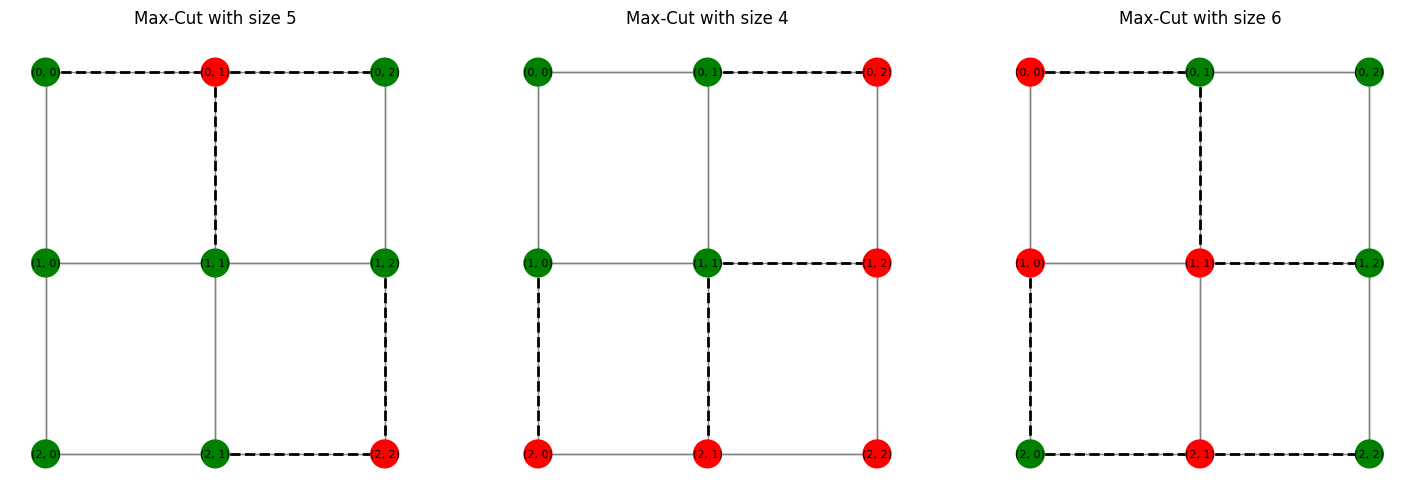

In [14]:
import matplotlib
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random


def random_cut_partition(graph):
    """Find a random partition for the Max-Cut problem."""
    partition = {}
    for node in graph.nodes():
        partition[node] = random.choice([0, 1])  # Randomly assign to one of two sets
    return partition

def plot_max_cut(graph, partition,ax):
    """Visualize the Max-Cut solution with colored nodes and dashed edges between cuts."""
    colors = ['red' if partition[node] == 0 else 'green' for node in graph.nodes()]
    pos = {(x,y):(y,-x) for x,y in graph.nodes()}
    
    # Identify edges that cross the cut
    cut_edges = [(u, v) for u, v in graph.edges() if partition[u] != partition[v]]
    same_set_edges = [(u, v) for u, v in graph.edges() if partition[u] == partition[v]]
    
  
    nx.draw(graph, pos, with_labels=True, node_color=colors, edge_color='gray', node_size=400, font_size=8,ax=ax)
    nx.draw_networkx_edges(graph, pos, edgelist=cut_edges, style='dashed', edge_color='black', width=2,ax=ax)
    nx.draw_networkx_edges(graph, pos, edgelist=same_set_edges, edge_color='gray', width=1,ax=ax)
    
    ax.set_title(f"Max-Cut with size {len(cut_edges)}")


# Create a simple 5-node graph
G = nx.grid_2d_graph(3,3)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Plot the graph with Max-Cut coloring
for i in range(len(axes)):
    plot_max_cut(G, random_cut_partition(G),axes[i])
plt.show()

## **Max-Cut Problem Formulation**

The **Max-Cut problem** is a fundamental problem in graph theory and combinatorial optimization. Given an **undirected graph** $ G = (V, E) $, where $ V $ is the set of vertices and $ E $ is the set of edges, the goal is to find a partition of the vertex set into two subsets $ S $ and $ \bar{S} $ that **maximizes the number (or total weight) of edges** that cross between the two subsets.

### **Mathematical Formulation**
Let:
- $ x_i $ be a binary decision variable for each vertex $ i $, where:
  $$
  x_i =
  \begin{cases}
  1, & \text{if node } i \text{ is in subset } S \\
  0, & \text{if node } i \text{ is in subset } \bar{S}
  \end{cases}
  $$
- Each edge $ (i, j) \in E $ contributes to the cut **if and only if** its endpoints are in different subsets, meaning $ x_i \neq x_j $.

The **Max-Cut objective function** is given by:
$$
\max \sum_{(i, j) \in E} w_{ij} (x_i \oplus x_j)
$$
where:
- $ w_{ij} $ is the weight of edge $ (i, j) $ (assumed 1 in the unweighted case).
- $ \oplus $ represents the **XOR** operation, which equals 1 if $ x_i \neq x_j $ (i.e., the edge is cut).




### **Reformulation in Terms of the Ising Model**
To solve the Max-Cut problem using **quantum optimization**, we express it in terms of spin variables:
- Define $ s_i $ as a spin variable taking values in $ \{-1, +1\} $, where:
  $$
  s_i = 2x_i - 1
  $$
- The Max-Cut objective function can then be rewritten as:
  $$
  \max \frac{1}{2} \sum_{(i, j) \in E} w_{ij} (1 - s_i s_j)
  $$
  Since minimizing $ s_i s_j $ encourages opposite spins (partitioning nodes into different sets), this formulation maps directly to the **Ising model**.


### **Quadratic Unconstrained Binary Optimization (QUBO) Formulation**
Since QUBO problems use binary variables $ x_i \in \{0,1\} $, we express Max-Cut as:
$$
\max \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2x_i x_j)
$$
which is a **quadratic** function of binary variables.

This formulation enables solving Max-Cut using classical and quantum optimization techniques, such as **QAOA (Quantum Approximate Optimization Algorithm)** and **Simulated Annealing**.


In [3]:
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
# create a QUBO for the unweighted MaxCut
qubo = QuadraticProgram()
linear={}
quadratic={}
for u in G.nodes():
    linear[str(u)] = 0
    qubo.binary_var(str(u))
for u,v in G.edges():
    linear[str(u)] += -1
    linear[str(v)] += -1
    quadratic[(str(u),str(v))]= 2
qubo.minimize(linear=linear, quadratic=quadratic)
print(qubo.prettyprint())

Problem name: 

Minimize
  2*(0, 0)*(0, 1) + 2*(0, 0)*(1, 0) + 2*(0, 1)*(0, 2) + 2*(0, 1)*(1, 1)
  + 2*(0, 2)*(1, 2) + 2*(1, 0)*(1, 1) + 2*(1, 0)*(2, 0) + 2*(1, 1)*(1, 2)
  + 2*(1, 1)*(2, 1) + 2*(1, 2)*(2, 2) + 2*(2, 0)*(2, 1) + 2*(2, 1)*(2, 2)
  - 2*(0, 0) - 3*(0, 1) - 2*(0, 2) - 3*(1, 0) - 4*(1, 1) - 3*(1, 2) - 2*(2, 0)
  - 3*(2, 1) - 2*(2, 2)

Subject to
  No constraints

  Binary variables (9)
    (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2)



In [4]:
exact_mes = NumPyMinimumEigensolver()
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: -12.0
variable values: (0, 0)=0.0, (0, 1)=1.0, (0, 2)=0.0, (1, 0)=1.0, (1, 1)=0.0, (1, 2)=1.0, (2, 0)=0.0, (2, 1)=1.0, (2, 2)=0.0
status: SUCCESS


In [5]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
partition = {node : int(exact_result.x[i]) for i,node in enumerate(G.nodes())  }
print(partition)
plot_max_cut(G, partition,ax=axes)
plt.show()

{(0, 0): 0, (0, 1): 1, (0, 2): 0, (1, 0): 1, (1, 1): 0, (1, 2): 1, (2, 0): 0, (2, 1): 1, (2, 2): 0}


# QAOA: Quantum Approximate Optimization Algorithm

In [6]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())

/tmp/ipykernel_18955/982656067.py:7: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())


In [7]:
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: -12.0
variable values: (0, 0)=0.0, (0, 1)=1.0, (0, 2)=0.0, (1, 0)=1.0, (1, 1)=0.0, (1, 2)=1.0, (2, 0)=0.0, (2, 1)=1.0, (2, 2)=0.0
status: SUCCESS


In [8]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
partition = {node : int(qaoa_result.x[i]) for i,node in enumerate(G.nodes())  }
print(partition)
plot_max_cut(G, partition,ax=axes)
plt.show()

{(0, 0): 0, (0, 1): 1, (0, 2): 0, (1, 0): 1, (1, 1): 0, (1, 2): 1, (2, 0): 0, (2, 1): 1, (2, 2): 0}


## **Analysis of Solution Samples**

The `OptimizationResult` object provides valuable insights through `SolutionSample`s (referred to as *samples* in this context). Each `SolutionSample` contains key information, including:

- **Input values (`x`)**: The specific variable assignment corresponding to the solution.
- **Objective function value (`fval`)**: The computed objective value for the given input.
- **Sample frequency (`probability`)**: The fraction of total samples that correspond to this particular solution.
- **Solution status (`status`)**: A classification indicating whether the solution is `SUCCESS`, `FAILURE`, or `INFEASIBLE`.

When multiple samples share the same input configuration, they are consolidated into a single `SolutionSample`. In such cases, the `probability` attribute reflects the aggregated proportion of occurrences for that particular solution. This structured representation allows for an efficient evaluation of optimization results, particularly in probabilistic and quantum computing scenarios.

In [9]:
print("variable order:", [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

variable order: ['(0, 0)', '(0, 1)', '(0, 2)', '(1, 0)', '(1, 1)', '(1, 2)', '(2, 0)', '(2, 1)', '(2, 2)']
SolutionSample(x=array([0., 1., 0., 1., 0., 1., 0., 1., 0.]), fval=-12.0, probability=0.0561285098616125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1., 0., 1., 0., 1., 0., 1.]), fval=-12.0, probability=0.0561285098616125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1., 0., 1., 0., 1., 0., 0.]), fval=-10.0, probability=0.009349401855382, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0., 1., 0., 1., 0., 1., 0.]), fval=-10.0, probability=0.009349401855382, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1., 1., 0., 1., 0., 1., 0.]), fval=-10.0, probability=0.009349401855382, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 1., 0., 1., 1., 1., 0.]), fval=-10.0, probability=0.009349401855382, status=<OptimizationResultStatu

# Practical example: The Travelling Salesman Problem (TSP)

In [10]:
import numpy as np
import networkx as nx
from qiskit_aer import Aer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import BackendSampler



# Create a TSP problem with 4 cities
num_cities = 5
adjacency_matrix = np.random.randint(1, 10, size=(num_cities, num_cities))
np.fill_diagonal(adjacency_matrix, 0)  # No self-loops

# Create a graph representation of the TSP
tsp = Tsp(adjacency_matrix)
qp = tsp.to_quadratic_program()
qubo = QuadraticProgramToQubo().convert(qp)
print(qubo.prettyprint())

# Set up the quantum backend
algorithm_globals.massive = True 
algorithm_globals.random_seed = 42
simulator = Aer.get_backend("aer_simulator")
simulator.set_options(
    max_parallel_threads=128,  # Use multiple threads
)
# Define the QAOA solver
qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)
qaoa_solver = MinimumEigenOptimizer(qaoa)

# Solve the TSP problem using QAOA
result = qaoa_solver.solve(qubo)

Problem name: TSP

Minimize
  802*x_0_0^2 + 802*x_0_0*x_0_1 + 802*x_0_0*x_0_2 + 802*x_0_0*x_0_3
  + 802*x_0_0*x_0_4 + 802*x_0_0*x_1_0 + x_0_0*x_1_1 + x_0_0*x_1_4
  + 802*x_0_0*x_2_0 + 4*x_0_0*x_2_1 + 4*x_0_0*x_2_4 + 802*x_0_0*x_3_0
  + 9*x_0_0*x_3_1 + 9*x_0_0*x_3_4 + 802*x_0_0*x_4_0 + 2*x_0_0*x_4_1
  + 2*x_0_0*x_4_4 + 802*x_0_1^2 + 802*x_0_1*x_0_2 + 802*x_0_1*x_0_3
  + 802*x_0_1*x_0_4 + x_0_1*x_1_0 + 802*x_0_1*x_1_1 + x_0_1*x_1_2
  + 4*x_0_1*x_2_0 + 802*x_0_1*x_2_1 + 4*x_0_1*x_2_2 + 9*x_0_1*x_3_0
  + 802*x_0_1*x_3_1 + 9*x_0_1*x_3_2 + 2*x_0_1*x_4_0 + 802*x_0_1*x_4_1
  + 2*x_0_1*x_4_2 + 802*x_0_2^2 + 802*x_0_2*x_0_3 + 802*x_0_2*x_0_4
  + x_0_2*x_1_1 + 802*x_0_2*x_1_2 + x_0_2*x_1_3 + 4*x_0_2*x_2_1
  + 802*x_0_2*x_2_2 + 4*x_0_2*x_2_3 + 9*x_0_2*x_3_1 + 802*x_0_2*x_3_2
  + 9*x_0_2*x_3_3 + 2*x_0_2*x_4_1 + 802*x_0_2*x_4_2 + 2*x_0_2*x_4_3
  + 802*x_0_3^2 + 802*x_0_3*x_0_4 + x_0_3*x_1_2 + 802*x_0_3*x_1_3 + x_0_3*x_1_4
  + 4*x_0_3*x_2_2 + 802*x_0_3*x_2_3 + 4*x_0_3*x_2_4 + 9*x_0_3*x_3_2
  + 802*x_

/tmp/ipykernel_18955/815721749.py:33: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa = QAOA(sampler=BackendSampler(backend=simulator), optimizer=COBYLA(), reps=3)


Optimal Route: [[3, 4], [0, 2], [0, 2], 1, 1]
Optimal Cost: 2445.0


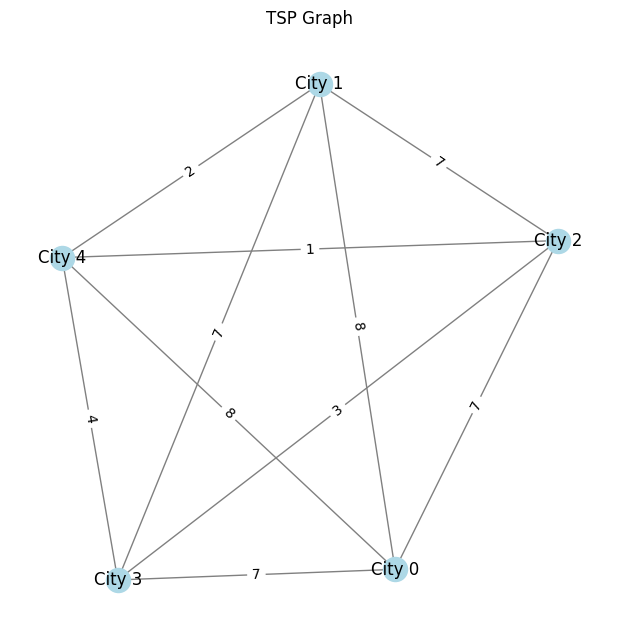

In [15]:
# Display results
print("Optimal Route:", tsp.interpret(result))
print("Optimal Cost:", result.fval)

# Draw the TSP graph
import matplotlib.pyplot as plt

G = nx.from_numpy_array(adjacency_matrix)
pos = nx.spring_layout(G)
labels = {i: f"City {i}" for i in range(num_cities)}

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", edge_color="gray")
edge_labels = {(i, j): adjacency_matrix[i, j] for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("TSP Graph")
plt.show()